Used metrics:
t(threshold)
AP(Average Precision)
mIOU(mean IOU)
IOUfg(Foreground IOU only)

In [1]:
import torch
import torchmetrics
import torchvision.transforms as transforms
from PIL import Image

c:\Users\yitao\.conda\envs\test\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# get image id and its name
METAFILE_DIR = "./dataset/metafiles/"

with open(METAFILE_DIR + "images.txt", "r") as f:
    lines = f.readlines()

img_names = []
for line in lines:
    parts = line.strip().split(" ")
    img_names.append(parts[1])

f.close()

In [3]:
# Load ground truth
MASKS_PATH = "./dataset/masks/"
GT_PATH = MASKS_PATH + "gt/"
CLIP_PATH = MASKS_PATH + "clipseg/"
DSS_PATH = MASKS_PATH + "dss/"

In [4]:
def toBinary(pred):
    one = torch.ones_like(pred)
    zero = torch.zeros_like(pred)
    pred_bi = torch.where(pred > 0, one, zero)
    return pred_bi

C:\Users\yitao\AppData\Local\Temp\ipykernel_20388\2568338570.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 1)


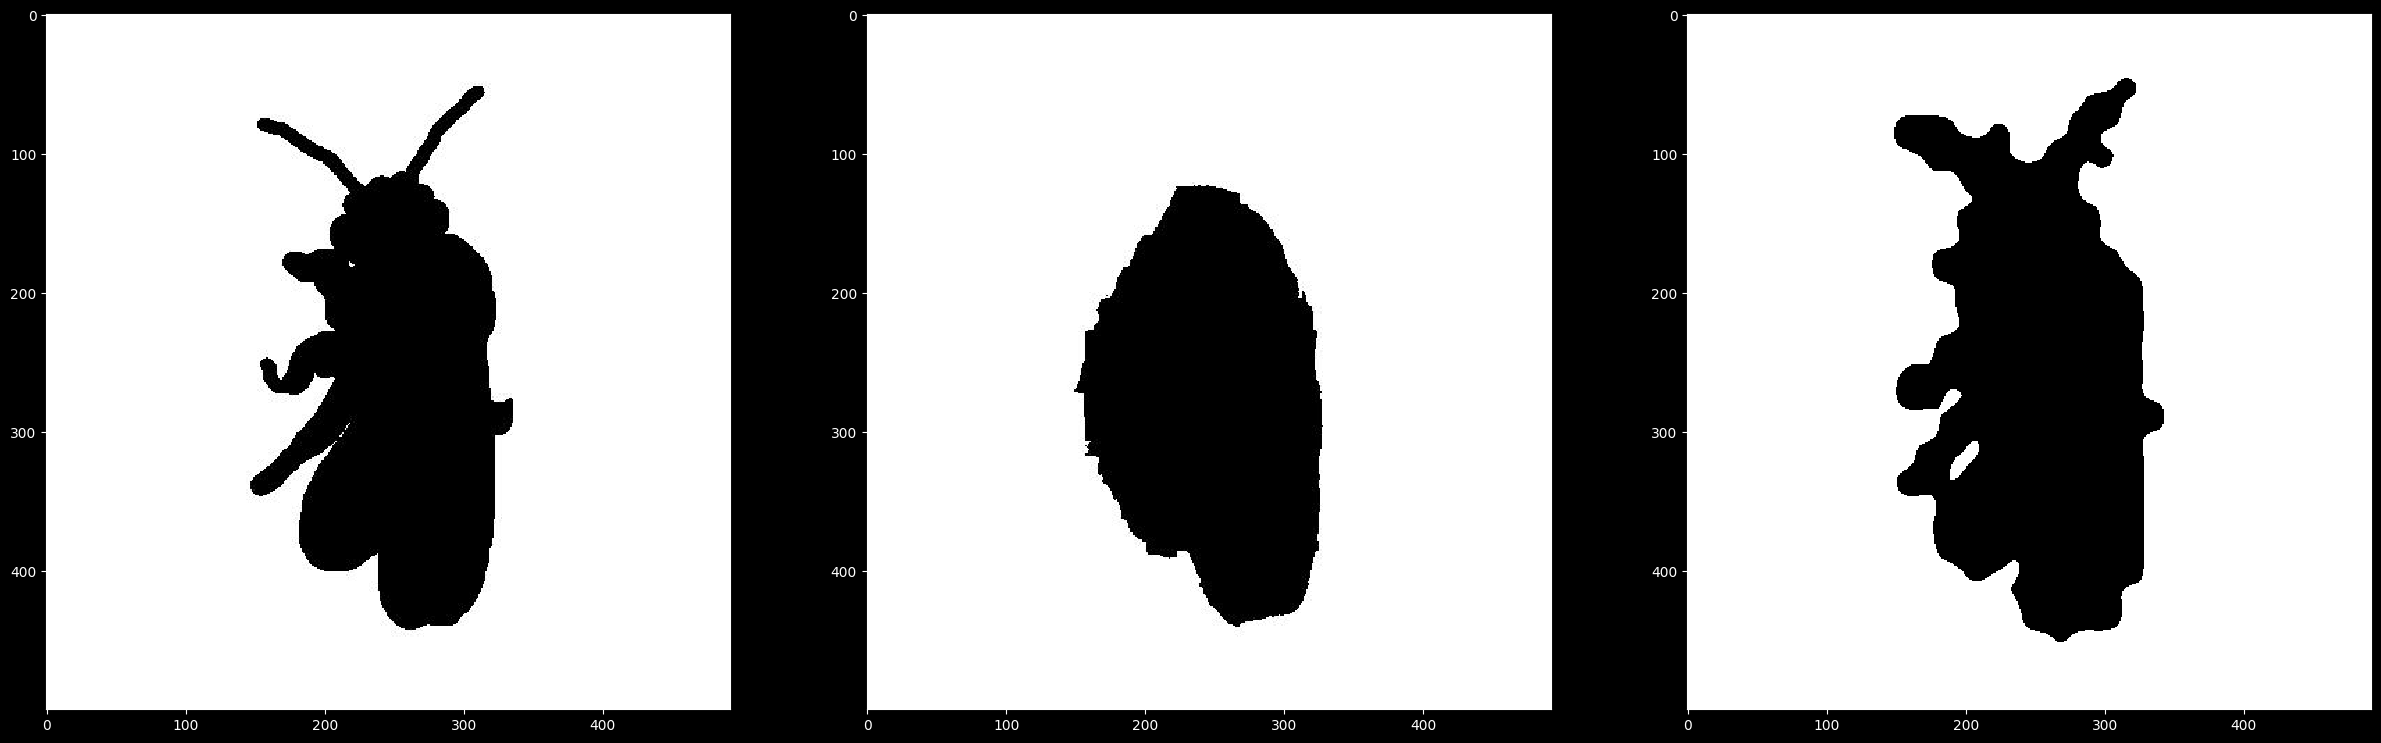

IOU_clipseg: 78.27%
IOU_dss: 84.14%


In [6]:
import matplotlib.pyplot as plt
from myutils.img_loader import get_img_by_id

id = 157
img_origin = get_img_by_id(id)
img_gt = get_img_by_id(id, GT_PATH)
img_clip = get_img_by_id(id, CLIP_PATH + "0.3/")
img_dss = get_img_by_id(id, DSS_PATH + "0/0.2/", "png")

toTensor = transforms.ToTensor()
mask_gt = toTensor(img_gt).squeeze(0)
mask_clip = toTensor(img_clip).squeeze(0)
mask_dss = toTensor(img_dss).squeeze(0)

# print(mask_gt.shape)
# print(mask_clip.shape)

plt.figure(figsize=(30, 20))

plt.subplot(1, 3, 1)
plt.imshow(img_origin, cmap="binary")
plt.subplot(2, 3, 1)
plt.imshow(mask_gt, interpolation="none", cmap="binary")
plt.subplot(2, 3, 2)
plt.imshow(mask_clip, interpolation="none", cmap="binary")
plt.subplot(2, 3, 3)
plt.imshow(mask_dss, interpolation="none", cmap="binary")

plt.show()

from torchmetrics.classification import BinaryJaccardIndex

mask_gt = toBinary(toTensor(img_gt).squeeze(0))
mask_clip = toBinary(toTensor(img_clip).squeeze(0))
mask_dss = toBinary(toTensor(img_dss).squeeze(0))
metric = BinaryJaccardIndex()
print("IOU_clipseg: " + str(round(metric(mask_clip, mask_gt).item() * 100, 2)) + "%")
print("IOU_dss: " + str(round(metric(mask_dss, mask_gt).item() * 100, 2)) + "%")

In [18]:
mask_gt.long()

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [21]:
from torchmetrics.classification import BinaryAveragePrecision

metric = BinaryAveragePrecision(thresholds=None)
metric(mask_clip, mask_gt.long())

tensor(0.1290)

In [14]:
# calculate overall IOU for CLIPSEG

metric = BinaryJaccardIndex()

thresholds = [0.1, 0.11, 0.12, 0.13, 0.15, 0.2, 0.25]
overall_ious = []

print("OVERALL IOUs: ")
for t in thresholds:
    ious = []
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_clip = get_img_by_id(i + 1, CLIP_PATH + str(t) + "/")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_clip = toBinary(toTensor(img_clip).squeeze(0))
        iou = round(metric(mask_clip, mask_gt).item() * 100, 2)
        ious.append(iou)

    overall_iou = round(sum(ious) / len(ious), 2)
    overall_ious.append(overall_iou)
    print("threshold = " + str(t) + ": overall IOU = " + str(overall_iou))

OVERALL IOUs: 
threshold = 0.1: overall IOU = 59.93
threshold = 0.11: overall IOU = 60.52
threshold = 0.12: overall IOU = 60.89
threshold = 0.13: overall IOU = 61.1
threshold = 0.15: overall IOU = 61.11
threshold = 0.2: overall IOU = 59.44
threshold = 0.25: overall IOU = 56.25


In [8]:
from torchmetrics.classification import BinaryAveragePrecision

# calculate overall Binary AP for CLIPSEG

metric_biAP = BinaryAveragePrecision(thresholds=None)

thresholds = [0.1, 0.11, 0.12, 0.13, 0.15, 0.2, 0.25]
overall_biaps = []

print("OVERALL binary APs: ")
for t in thresholds:
    biaps = []
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_clip = get_img_by_id(i + 1, CLIP_PATH + str(t) + "/")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_clip = toBinary(toTensor(img_clip).squeeze(0))
        biap = round(metric_biAP(mask_clip, mask_gt.long()).item() * 100, 2)
        biaps.append(biap)

    overall_biap = round(sum(biaps) / len(biaps), 2)
    overall_biaps.append(overall_biap)
    print("threshold(" + str(t) + ") | overall binay AP = " + str(overall_biap))

OVERALL binary APs: 
threshold(0.1) | overall binay AP = 60.68
threshold(0.11) | overall binay AP = 61.4
threshold(0.12) | overall binay AP = 61.9
threshold(0.13) | overall binay AP = 62.27
threshold(0.15) | overall binay AP = 62.6
threshold(0.2) | overall binay AP = 61.83
threshold(0.25) | overall binay AP = 59.66


In [ ]:
# calculate overall IOU for DEEP_SPECTRAL_SEGMENTATION


metric = BinaryJaccardIndex()

thresholds = [0.2]
overall_ious = []

print("OVERALL IOUs: ")
for t in thresholds:
    ious = []
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_dss = get_img_by_id(i + 1, DSS_PATH + "0/0.2/", "png")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_dss = toBinary(toTensor(img_dss).squeeze(0))
        iou = round(metric(mask_dss, mask_gt).item() * 100, 2)
        ious.append(iou)

    overall_iou = round(sum(ious) / len(ious), 2)
    overall_ious.append(overall_iou)
    print("threshold = " + str(t) + ": overall IOU = " + str(overall_iou))

In [ ]:
from torchmetrics.classification import BinaryAveragePrecision

# calculate overall Binary AP for DEEPSPEC

metric_biAP = BinaryAveragePrecision(thresholds=None)

thresholds = [0.2]
overall_biaps = []

print("OVERALL binary APs: ")
for t in thresholds:
    biaps = []
    for i in range(len(img_names)):
        img_gt = get_img_by_id(i + 1, GT_PATH)
        img_dss = get_img_by_id(i + 1, DSS_PATH + "0/0.2/", "png")
        mask_gt = toBinary(toTensor(img_gt).squeeze(0))
        mask_dss = toBinary(toTensor(img_dss).squeeze(0))
        biap = round(metric_biAP(mask_dss, mask_gt.long()).item() * 100, 2)
        biaps.append(biap)

    overall_biap = round(sum(biaps) / len(biaps), 2)
    overall_biaps.append(overall_biap)
    print("threshold(" + str(t) + ") | overall binay AP = " + str(overall_biap))